In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import AdamW
from tqdm import tqdm

In [ ]:
seed = 123

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Download data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Deep_learning/Terra_Quantum/DL_seminars/seminar_5/archive.zip

Archive:  /content/drive/MyDrive/Deep_learning/Terra_Quantum/DL_seminars/seminar_5/archive.zip
  inflating: bbc-text.csv            


In [ ]:
datapath = f'/content/bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.loc[0].text

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

<Axes: xlabel='category'>

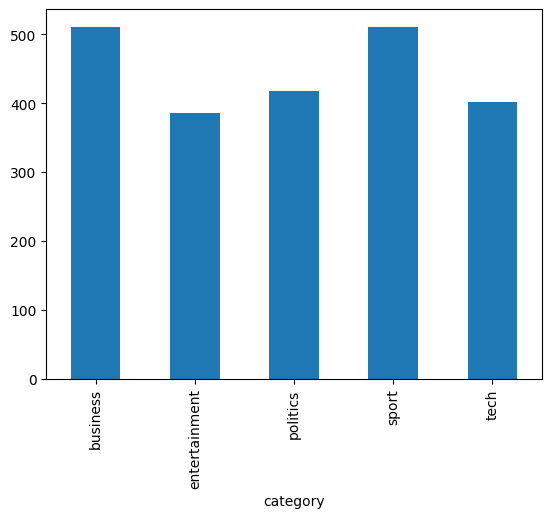

In [ ]:
df.groupby(['category']).size().plot.bar()

### Create Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

### Create model

In [ ]:
BertModel.from_pretrained('bert-base-cased')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id,
                                     attention_mask=mask,
                                     return_dict=False)

        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)

        return linear_output

### Train loop

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs, batch_size, num_batch_accum = 1):

    train_dataset, val_dataset = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for i, (train_input, train_label) in enumerate(tqdm(train_dataloader)):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long()) / num_batch_accum
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()

            if (i + 1) % num_batch_accum == 0:
                optimizer.step()
                model.zero_grad()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | \
            Train Accuracy: {total_acc_train / len(train_data): .3f} | \
            Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [ ]:
EPOCHS = 20
model = BertClassifier()
LR = 1e-6
BATCH_SIZE = 25

train(model, df_train, df_val, LR, EPOCHS, BATCH_SIZE)

100%|██████████| 71/71 [02:34<00:00,  2.18s/it]


Epochs: 1 | Train Loss:  0.066 |             Train Accuracy:  0.222 |             Val Loss:  0.061 | Val Accuracy:  0.320


100%|██████████| 71/71 [02:47<00:00,  2.35s/it]


Epochs: 2 | Train Loss:  0.059 |             Train Accuracy:  0.337 |             Val Loss:  0.054 | Val Accuracy:  0.396


100%|██████████| 71/71 [02:48<00:00,  2.38s/it]


Epochs: 3 | Train Loss:  0.052 |             Train Accuracy:  0.437 |             Val Loss:  0.048 | Val Accuracy:  0.563


100%|██████████| 71/71 [02:48<00:00,  2.37s/it]


Epochs: 4 | Train Loss:  0.045 |             Train Accuracy:  0.589 |             Val Loss:  0.039 | Val Accuracy:  0.721


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 5 | Train Loss:  0.037 |             Train Accuracy:  0.722 |             Val Loss:  0.032 | Val Accuracy:  0.851


100%|██████████| 71/71 [02:48<00:00,  2.38s/it]


Epochs: 6 | Train Loss:  0.029 |             Train Accuracy:  0.849 |             Val Loss:  0.025 | Val Accuracy:  0.901


100%|██████████| 71/71 [02:49<00:00,  2.39s/it]


Epochs: 7 | Train Loss:  0.023 |             Train Accuracy:  0.908 |             Val Loss:  0.021 | Val Accuracy:  0.946


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 8 | Train Loss:  0.018 |             Train Accuracy:  0.944 |             Val Loss:  0.016 | Val Accuracy:  0.973


100%|██████████| 71/71 [02:49<00:00,  2.39s/it]


Epochs: 9 | Train Loss:  0.014 |             Train Accuracy:  0.970 |             Val Loss:  0.012 | Val Accuracy:  0.977


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 10 | Train Loss:  0.012 |             Train Accuracy:  0.977 |             Val Loss:  0.010 | Val Accuracy:  0.977


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 11 | Train Loss:  0.009 |             Train Accuracy:  0.979 |             Val Loss:  0.008 | Val Accuracy:  0.991


100%|██████████| 71/71 [02:48<00:00,  2.38s/it]


Epochs: 12 | Train Loss:  0.008 |             Train Accuracy:  0.981 |             Val Loss:  0.007 | Val Accuracy:  0.986


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 13 | Train Loss:  0.007 |             Train Accuracy:  0.985 |             Val Loss:  0.006 | Val Accuracy:  0.995


100%|██████████| 71/71 [02:49<00:00,  2.38s/it]


Epochs: 14 | Train Loss:  0.006 |             Train Accuracy:  0.984 |             Val Loss:  0.006 | Val Accuracy:  0.986


 75%|███████▍  | 53/71 [02:06<00:42,  2.38s/it]

### Test

In [ ]:
evaluate(model, df_test)

---